# Fast Campus Data Science School 7th

## Regression Team Project

### Overview
- Team: Team B-5 committer (김선웅, 이영인, 장승우)
- Subject: New York City Taxi Trip Duration
- Dataset: 2016 NYC Cab trip record data (by TLC)
- Objective: Building a model that predicts the duration of each trip in New York City.

#### Data fields
- id - 각 운행별 고유 id
- vendor_id - 운행별 각 택시 회사의 id
- pickup_datetime - 승차 날짜/시각 (미터기 기록 시작)
- dropoff_datetime - 하차 날짜/시각 (미터기 기록 종료)
- passenger_count - 승객 수
- pickup_longitude - 승차 위도
- pickup_latitude - 승차 경도
- dropoff_longitude - 하차 위도
- dropoff_latitude - 하차 경도
- store_and_fwd_flag - 운행 기록 서비 전송 전 차량 메모리 저장 여부 (Y: 저장/전송, N: 미저장/전송)
- trip_duration - 운행 소요 시간 (초)

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import scipy as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms 
import sklearn as sk

from patsy import dmatrix

import matplotlib.pyplot as plt

import seaborn as sns
sns.set()

%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'retina'}

from matplotlib import font_manager, rc
plt.rcParams['axes.unicode_minus'] = False

import platform
if platform.system() == 'Darwin':
    rc('font', family='AppleGothic')
elif platform.system() == 'Windows':
    path = "c:/Windows/Fonts/malgun.ttf"
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)

import warnings
warnings.filterwarnings("ignore")

/Users/sunwoongkim/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
train = pd.read_csv("../dataset/train.csv", parse_dates=["pickup_datetime", "dropoff_datetime"])
print("Shape of Train Data: ", train.shape)

Shape of Train Data:  (1458644, 11)


In [3]:
train["pickup_month"] = train["pickup_datetime"].dt.month
train["pickup_weekday"] = train["pickup_datetime"].dt.weekday
train["pickup_hour"] = train["pickup_datetime"].dt.hour

train.shape

(1458644, 14)

In [4]:
working_day = [0, 1, 2, 3, 4] # Mon-Fri
train["working_day"] = train["pickup_weekday"].isin(working_day).astype(int)

In [5]:
train["store_and_fwd_flag"] = 1 * (train.store_and_fwd_flag.values == 'Y')

In [6]:
lat1, lng1, lat2, lng2 = (train['pickup_latitude'].values, train['pickup_longitude'].values, 
                          train['dropoff_latitude'].values, train['dropoff_longitude'].values)

In [7]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

In [8]:
def bearing_array(lat1, lng1, lat2, lng2):
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return (np.degrees(np.arctan2(y, x)) + 360) % 360 # from -180/180 to 0/360

In [9]:
train = train.assign(distance = haversine_array(lat1, lng1, lat2, lng2))
train = train.assign(bearing = bearing_array(lat1, lng1, lat2, lng2))

In [10]:
X_cols = [col for col in train.columns if col != "trip_duration"]
train_X0 = train[X_cols]
train_y = train[["trip_duration"]]

In [11]:
col_real = ["passenger_count", "distance", "bearing", "pickup_longitude", 
            "pickup_latitude", "dropoff_longitude", "dropoff_latitude"]

col_cats = [col for col in train.columns if col not in col_real]
for col in ["pickup_datetime", "dropoff_datetime", "id"]:
    col_cats.remove(col)
col_cats_nontime = ["vendor_id", "store_and_fwd_flag", "working_day"]

In [12]:
model = sm.OLS.from_formula("trip_duration ~ passenger_count + distance + bearing + pickup_month +" 
                            "pickup_weekday + pickup_hour + pickup_latitude + pickup_longitude +"
                            "dropoff_latitude + dropoff_longitude + C(vendor_id) + C(store_and_fwd_flag)"
                            "+ C(working_day)", train)
result_01 = model.fit()

In [13]:
# print(result_01.summary())

In [14]:
result_sets = pd.DataFrame(columns=["R_squared", "Adj.R_squared", "AIC", "BIC", "P_fstatics", 
                                    "P_omnibus", "P_jb", "Cond_no", "changed"])

In [15]:
# 수정본 (Team B-5)
# 전역변수로 result_sets을 선언하고 사용

def storage(result, change) :
    
    summary = result.summary()
    table = summary.tables[2]
    
    p_omnibus = float(table.data[1][1])
    p_jb = float(table.data[2][3])
    
    put = {
        "R_squared" : result.rsquared,
        "Adj.R_squared": result.rsquared_adj,
        "AIC" : result.aic,
        "BIC" : result.bic,
        "P_fstatics" : result.f_pvalue,
        "P_omnibus" : p_omnibus,
        "P_jb" : p_jb,
        "Cond_no" : result.condition_number, 
        "changed" : change,
    }
    
    result_sets.loc[len(result_sets)] = put

## poly10

In [16]:
model = sm.OLS.from_formula("np.log1p(trip_duration) ~ np.log1p(distance) +" 
                            "scale(I(pickup_hour**2)) + scale(I(pickup_hour**4))+"
                            "scale(dropoff_latitude) + C(working_day)", train)
result = model.fit()
print(result.summary())

                               OLS Regression Results                              
Dep. Variable:     np.log1p(trip_duration)   R-squared:                       0.589
Model:                                 OLS   Adj. R-squared:                  0.589
Method:                      Least Squares   F-statistic:                 4.174e+05
Date:                     Tue, 13 Mar 2018   Prob (F-statistic):               0.00
Time:                             16:28:45   Log-Likelihood:            -1.0887e+06
No. Observations:                  1458644   AIC:                         2.177e+06
Df Residuals:                      1458638   BIC:                         2.177e+06
Df Model:                                5                                         
Covariance Type:                 nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

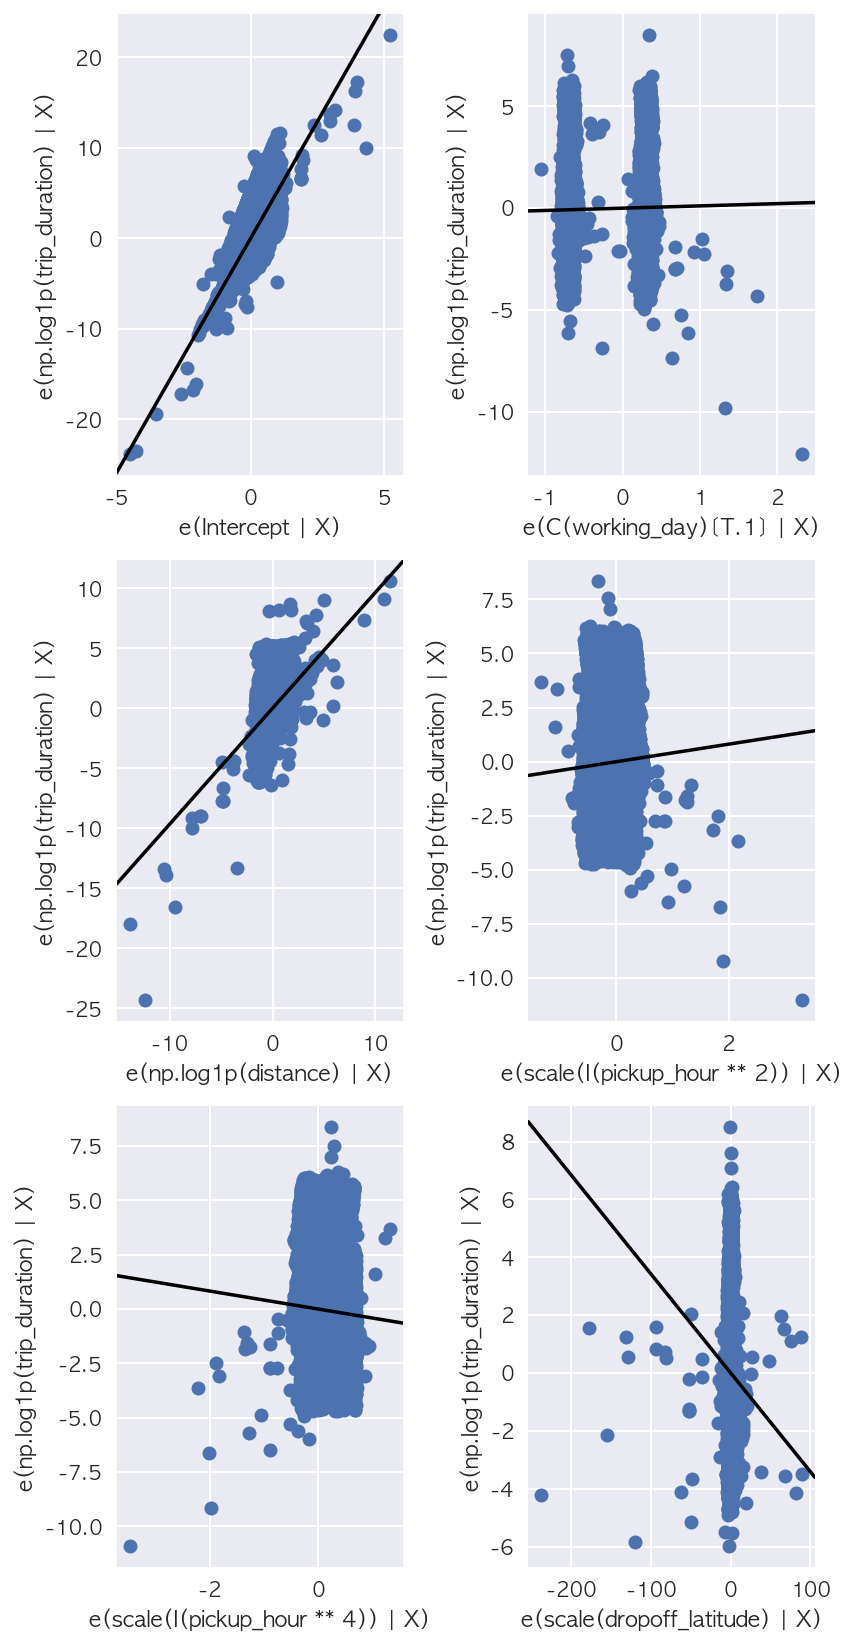

In [17]:
fig = plt.figure(figsize=(6, 12))
sm.graphics.plot_partregress_grid(result, fig=fig)
fig.suptitle("")
plt.show()

In [18]:
influence = result.get_influence()
hat = influence.hat_matrix_diag

In [19]:
# plt.figure(figsize=(10, 2))
# plt.stem(hat[::1000])
# plt.show()

In [20]:
idx = np.where(hat > 3 * hat.mean())[0]
len(idx)

26544

In [21]:
train_out_01 = train.copy()

In [22]:
len(train), len(train_out_01.drop(idx))

(1458644, 1432100)

In [23]:
train_out_01.drop(idx, inplace=True)

In [24]:
train_out_01.reset_index(drop=True, inplace=True)

In [25]:
storage(result, "poly10")

In [26]:
result_sets

,R_squared,Adj.R_squared,AIC,BIC,P_fstatics,P_omnibus,P_jb,Cond_no,changed
0,0.588629,0.588627,2.177331e+06,2.177404e+06,0.0,0.0,0.0,9.404033,poly10


## 2. outlier 제거 (레버리지 평균의 3배)

In [27]:
model = sm.OLS.from_formula("np.log1p(trip_duration) ~ np.log1p(distance) +" 
                            "scale(I(pickup_hour**2)) + scale(I(pickup_hour**4))+"
                            "scale(dropoff_latitude) + C(working_day)", train_out_01)
result_02 = model.fit()
print(result_02.summary())

                               OLS Regression Results                              
Dep. Variable:     np.log1p(trip_duration)   R-squared:                       0.580
Model:                                 OLS   Adj. R-squared:                  0.580
Method:                      Least Squares   F-statistic:                 3.962e+05
Date:                     Tue, 13 Mar 2018   Prob (F-statistic):               0.00
Time:                             16:30:05   Log-Likelihood:            -1.0560e+06
No. Observations:                  1432100   AIC:                         2.112e+06
Df Residuals:                      1432094   BIC:                         2.112e+06
Df Model:                                5                                         
Covariance Type:                 nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

In [28]:
storage(result_02, "레버리지 평균 3배 이상 제거")

In [29]:
result_sets

,R_squared,Adj.R_squared,AIC,BIC,P_fstatics,P_omnibus,P_jb,Cond_no,changed
0,0.588629,0.588627,2.177331e+06,2.177404e+06,0.0,0.0,0.0,9.404033,poly10
1,0.580441,0.580439,2.111924e+06,2.111997e+06,0.0,0.0,0.0,9.293296,레버리지 평균 3배 이상 제거


In [30]:
# fig = plt.figure(figsize=(8, 14))
# sm.graphics.plot_partregress_grid(result_02, fig=fig)
# fig.suptitle("")
# plt.show()

In [31]:
influence = result_02.get_influence()
hat = influence.hat_matrix_diag

In [32]:
# plt.figure(figsize=(10, 2))
# plt.stem(hat[::1000])
# plt.show()

In [33]:
idx = np.where(hat > 3 * hat.mean())[0]
len(idx)

18357

In [34]:
train_out_02 = train_out_01.copy()

In [35]:
train_out_02.drop(idx, inplace=True)

In [36]:
train_out_02.reset_index(drop=True, inplace=True)

## 3. 2의 레버리지 3배 이상 제거

In [38]:
model = sm.OLS.from_formula("np.log1p(trip_duration) ~ np.log1p(distance) +" 
                            "scale(I(pickup_hour**2)) + scale(I(pickup_hour**4))+"
                            "scale(dropoff_latitude) + C(working_day)", train_out_02)
result_03 = model.fit()
print(result_03.summary())

                               OLS Regression Results                              
Dep. Variable:     np.log1p(trip_duration)   R-squared:                       0.579
Model:                                 OLS   Adj. R-squared:                  0.579
Method:                      Least Squares   F-statistic:                 3.882e+05
Date:                     Tue, 13 Mar 2018   Prob (F-statistic):               0.00
Time:                             15:05:12   Log-Likelihood:            -1.0294e+06
No. Observations:                  1413743   AIC:                         2.059e+06
Df Residuals:                      1413737   BIC:                         2.059e+06
Df Model:                                5                                         
Covariance Type:                 nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

In [39]:
storage(result_03, "2의 레버리지 3배 이상 제거")

In [40]:
result_sets

,R_squared,Adj.R_squared,AIC,BIC,P_fstatics,P_omnibus,P_jb,Cond_no,changed
0,0.588629,0.588627,2.177331e+06,2.177404e+06,0.0,0.0,0.0,9.404033,poly10
1,0.580441,0.580439,2.111924e+06,2.111997e+06,0.0,0.0,0.0,9.293296,레버리지 평균 3배 이상 제거
2,0.578570,0.578569,2.058747e+06,2.058820e+06,0.0,0.0,0.0,9.227337,2의 레버리지 3배 이상 제거


In [41]:
y = train_out_02.loc[:, ["trip_duration"]]
x = train_out_02.loc[:, ["distance"]]

In [ ]:
model = sm.OLS.from_formula("np.log1p(trip_duration) ~ np.log1p(distance) +" 
                            "abs(np.sin(pickup_hour)) +"
                            "scale(dropoff_latitude) + C(working_day)", train)
result_02 = model.fit()
print(result_02.summary())

In [ ]:
fig = plt.figure(figsize=(8, 20))
sm.graphics.plot_partregress_grid(result_02, fig=fig)
fig.suptitle("")
plt.show()

In [43]:
model = sm.OLS.from_formula("np.log1p(trip_duration) ~ np.log1p(distance) +" 
                            "scale(I(pickup_hour**2)) + scale(I(pickup_hour**4))+"
                            "scale(dropoff_latitude) + working_day", train_out_01)
result_03 = model.fit()
print(result_03.summary())

                               OLS Regression Results                              
Dep. Variable:     np.log1p(trip_duration)   R-squared:                       0.580
Model:                                 OLS   Adj. R-squared:                  0.580
Method:                      Least Squares   F-statistic:                 3.962e+05
Date:                     Tue, 13 Mar 2018   Prob (F-statistic):               0.00
Time:                             15:06:53   Log-Likelihood:            -1.0560e+06
No. Observations:                  1432100   AIC:                         2.112e+06
Df Residuals:                      1432094   BIC:                         2.112e+06
Df Model:                                5                                         
Covariance Type:                 nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

In [37]:
train_out_01 = train_out_01[train_out_01["trip_duration"] < 150000]

In [38]:
model = sm.OLS.from_formula("scale(trip_duration) ~ scale(distance) +" 
                            "scale(I(pickup_hour**2)) + scale(I(pickup_hour**4))+"
                            "+ scale(bearing) + C(working_day) + pickup_month", train_out_01)
result_04 = model.fit()
print(result_04.summary())

                             OLS Regression Results                             
Dep. Variable:     scale(trip_duration)   R-squared:                       0.025
Model:                              OLS   Adj. R-squared:                  0.025
Method:                   Least Squares   F-statistic:                     6100.
Date:                  Tue, 13 Mar 2018   Prob (F-statistic):               0.00
Time:                          16:31:33   Log-Likelihood:            -2.0140e+06
No. Observations:               1432096   AIC:                         4.028e+06
Df Residuals:                   1432089   BIC:                         4.028e+06
Df Model:                             6                                         
Covariance Type:              nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------


In [39]:
influence = result_04.get_influence()
hat = influence.hat_matrix_diag

In [42]:
idx = np.where(hat > 3*hat.mean())[0]
train_out_01.drop(idx, inplace=True)
train_out_01.reset_index(drop=True, inplace=True)

In [43]:
train_out_01.shape[0]

1406918

In [44]:
model = sm.OLS.from_formula("scale(trip_duration) ~ scale(distance) +" 
                            "scale(pickup_hour) + scale(I(pickup_hour**2)) + scale(I(pickup_hour**4))+"
                            "+ scale(bearing) + C(working_day) + pickup_month", train_out_01)
result_05 = model.fit()
print(result_05.summary())

                             OLS Regression Results                             
Dep. Variable:     scale(trip_duration)   R-squared:                       0.023
Model:                              OLS   Adj. R-squared:                  0.023
Method:                   Least Squares   F-statistic:                     4799.
Date:                  Tue, 13 Mar 2018   Prob (F-statistic):               0.00
Time:                          16:33:07   Log-Likelihood:            -1.9797e+06
No. Observations:               1406918   AIC:                         3.959e+06
Df Residuals:                   1406910   BIC:                         3.960e+06
Df Model:                             7                                         
Covariance Type:              nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------


In [45]:
influence = result_05.get_influence()
cooks_d2, pvals = influence.cooks_distance
fox_cr = 4 / (len(train) - 2)
idx = np.where(cooks_d2 > fox_cr)[0]

In [46]:
train_out_01.drop(idx, inplace=True)
train_out_01.reset_index(drop=True, inplace=True)
len(train_out_01)

1404731

In [47]:
model = sm.OLS.from_formula("np.log1p(trip_duration) ~ np.log1p(distance) +" 
                            "scale(I(pickup_hour**2)) + scale(I(pickup_hour**4))+"
                            "scale(dropoff_latitude) + working_day", train_out_01)
result_06 = model.fit()
print(result_06.summary())

                               OLS Regression Results                              
Dep. Variable:     np.log1p(trip_duration)   R-squared:                       0.609
Model:                                 OLS   Adj. R-squared:                  0.609
Method:                      Least Squares   F-statistic:                 4.381e+05
Date:                     Tue, 13 Mar 2018   Prob (F-statistic):               0.00
Time:                             16:33:44   Log-Likelihood:            -9.3787e+05
No. Observations:                  1404731   AIC:                         1.876e+06
Df Residuals:                      1404725   BIC:                         1.876e+06
Df Model:                                5                                         
Covariance Type:                 nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

In [48]:
idx = np.where(result_06.resid_pearson > 2)[0]

In [49]:
train_out_01.drop(idx, inplace=True)
train_out_01.reset_index(drop=True, inplace=True)

In [50]:
len(train_out_01)

1378031

In [51]:
model = sm.OLS.from_formula("np.log1p(trip_duration) ~ np.log1p(distance) +" 
                            "scale(I(pickup_hour**2)) + scale(I(pickup_hour**4))+"
                            "scale(dropoff_latitude) + working_day", train_out_01)
result_07 = model.fit()
print(result_07.summary())

                               OLS Regression Results                              
Dep. Variable:     np.log1p(trip_duration)   R-squared:                       0.657
Model:                                 OLS   Adj. R-squared:                  0.657
Method:                      Least Squares   F-statistic:                 5.284e+05
Date:                     Tue, 13 Mar 2018   Prob (F-statistic):               0.00
Time:                             16:34:33   Log-Likelihood:            -8.2220e+05
No. Observations:                  1378031   AIC:                         1.644e+06
Df Residuals:                      1378025   BIC:                         1.644e+06
Df Model:                                5                                         
Covariance Type:                 nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

In [53]:
hat = result_07.get_influence().hat_matrix_diag

In [58]:
idx = np.where(hat > 2 * hat.mean())[0]
len(idx)

101371

In [59]:
train_out_01.drop(idx, inplace=True)
train_out_01.reset_index(drop=True, inplace=True)
len(train_out_01)

1276660

In [66]:
model = sm.OLS.from_formula("scale(trip_duration) ~ scale(distance) + scale(I(distance**2))+" 
                            "scale(I(pickup_hour**2)) + scale(I(pickup_hour**4))+"
                            "scale(dropoff_latitude) + working_day", train_out_01)
result_08 = model.fit()
print(result_08.summary())

                             OLS Regression Results                             
Dep. Variable:     scale(trip_duration)   R-squared:                       0.651
Model:                              OLS   Adj. R-squared:                  0.651
Method:                   Least Squares   F-statistic:                 3.965e+05
Date:                  Tue, 13 Mar 2018   Prob (F-statistic):               0.00
Time:                          16:42:18   Log-Likelihood:            -1.1400e+06
No. Observations:               1276660   AIC:                         2.280e+06
Df Residuals:                   1276653   BIC:                         2.280e+06
Df Model:                             6                                         
Covariance Type:              nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------


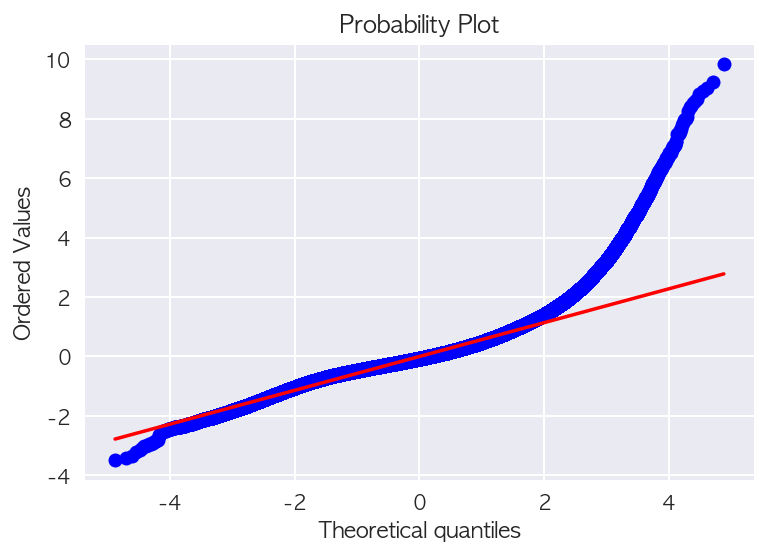

In [67]:
sp.stats.probplot(result_08.resid, plot=plt)
plt.show()

In [69]:
idx = np.where(result_08.resid_pearson > 2)[0]
len(idx)

46402

In [70]:
train_out_01.drop(idx, inplace=True)
train_out_01.reset_index(drop=True, inplace=True)
len(train_out_01)

1230258

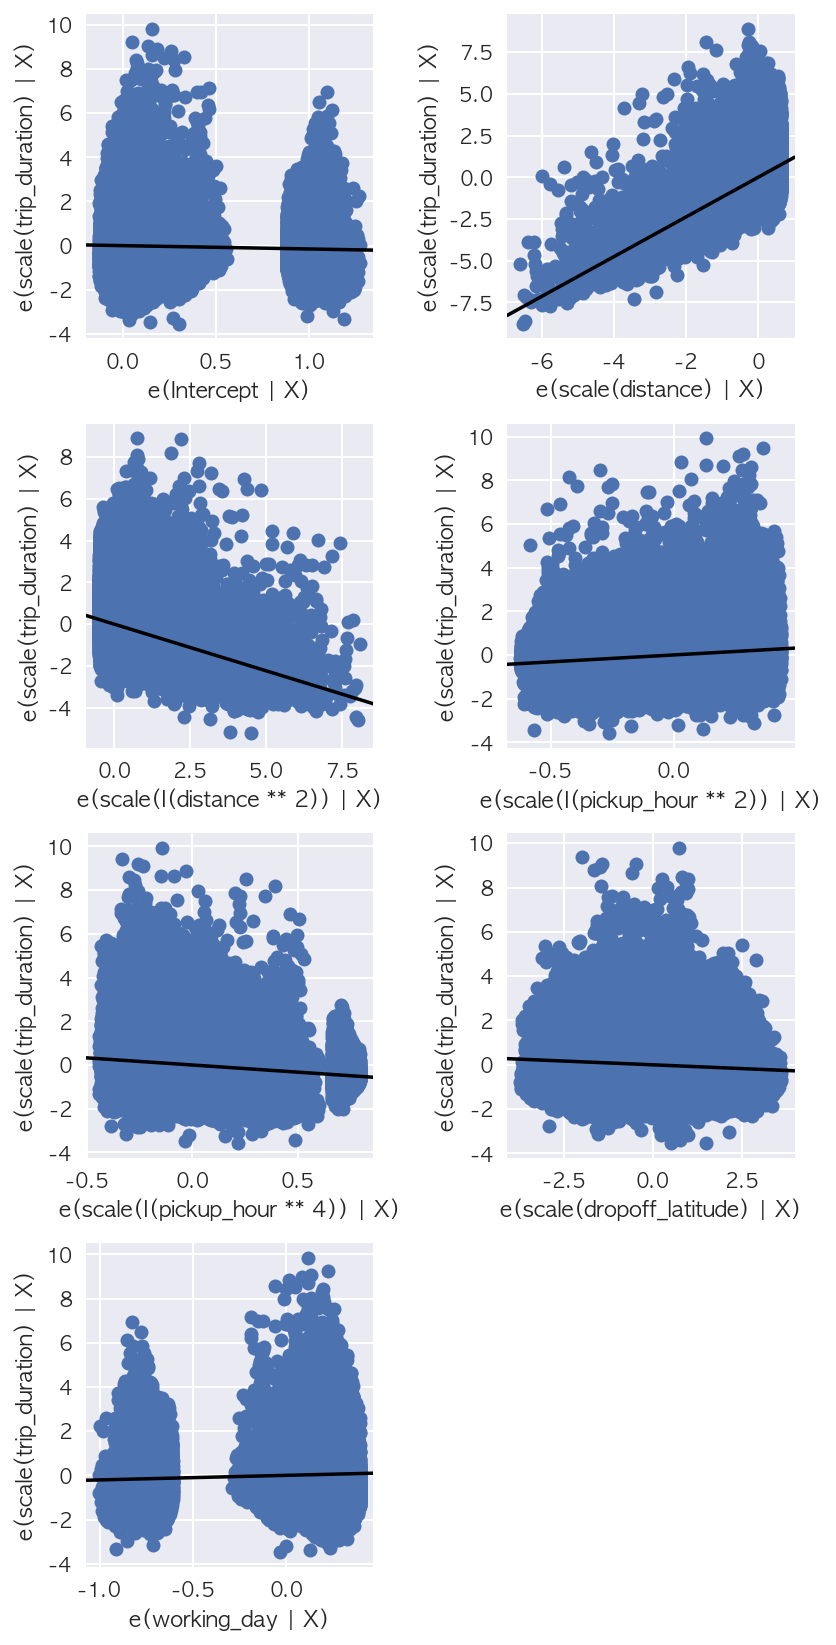

In [68]:
fig = plt.figure(figsize=(6, 12))
sm.graphics.plot_partregress_grid(result_08, fig=fig)
fig.suptitle("")
plt.show()

In [71]:
model = sm.OLS.from_formula("scale(trip_duration) ~ scale(distance) + scale(I(distance**2))+" 
                            "scale(I(pickup_hour**2)) + scale(I(pickup_hour**4))+"
                            "scale(dropoff_latitude) + working_day", train_out_01)
result_09 = model.fit()
print(result_09.summary())

                             OLS Regression Results                             
Dep. Variable:     scale(trip_duration)   R-squared:                       0.686
Model:                              OLS   Adj. R-squared:                  0.686
Method:                   Least Squares   F-statistic:                 4.483e+05
Date:                  Tue, 13 Mar 2018   Prob (F-statistic):               0.00
Time:                          16:47:05   Log-Likelihood:            -1.0328e+06
No. Observations:               1230258   AIC:                         2.066e+06
Df Residuals:                   1230251   BIC:                         2.066e+06
Df Model:                             6                                         
Covariance Type:              nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------


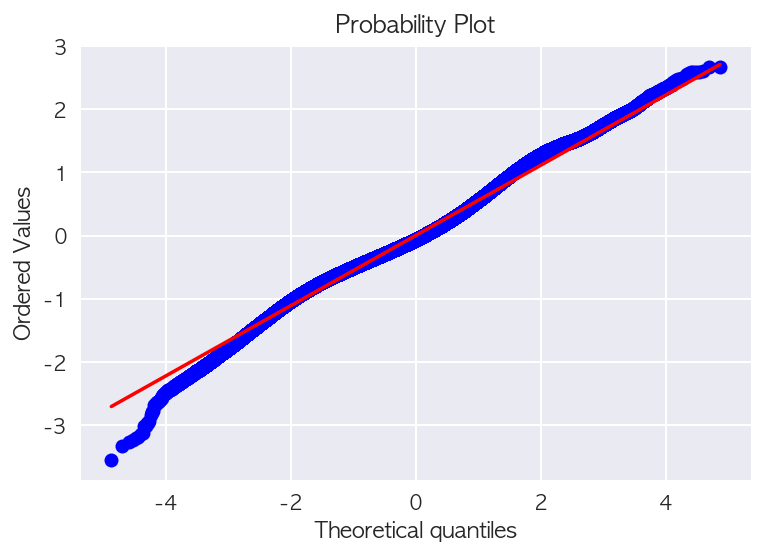

In [72]:
sp.stats.probplot(result_09.resid, plot=plt)
plt.show()

In [75]:
model = sm.OLS.from_formula("scale(trip_duration) ~ scale(distance) + scale(I(distance**2))+" 
                            "scale(I(pickup_hour**2)) + scale(I(pickup_hour**4))+"
                            "scale(dropoff_latitude) + working_day", train_out_01)
result_10 = model.fit()
print(result_10.summary())

                             OLS Regression Results                             
Dep. Variable:     scale(trip_duration)   R-squared:                       0.690
Model:                              OLS   Adj. R-squared:                  0.690
Method:                   Least Squares   F-statistic:                 3.906e+05
Date:                  Tue, 13 Mar 2018   Prob (F-statistic):               0.00
Time:                          16:50:59   Log-Likelihood:            -1.0258e+06
No. Observations:               1230258   AIC:                         2.052e+06
Df Residuals:                   1230250   BIC:                         2.052e+06
Df Model:                             7                                         
Covariance Type:              nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------


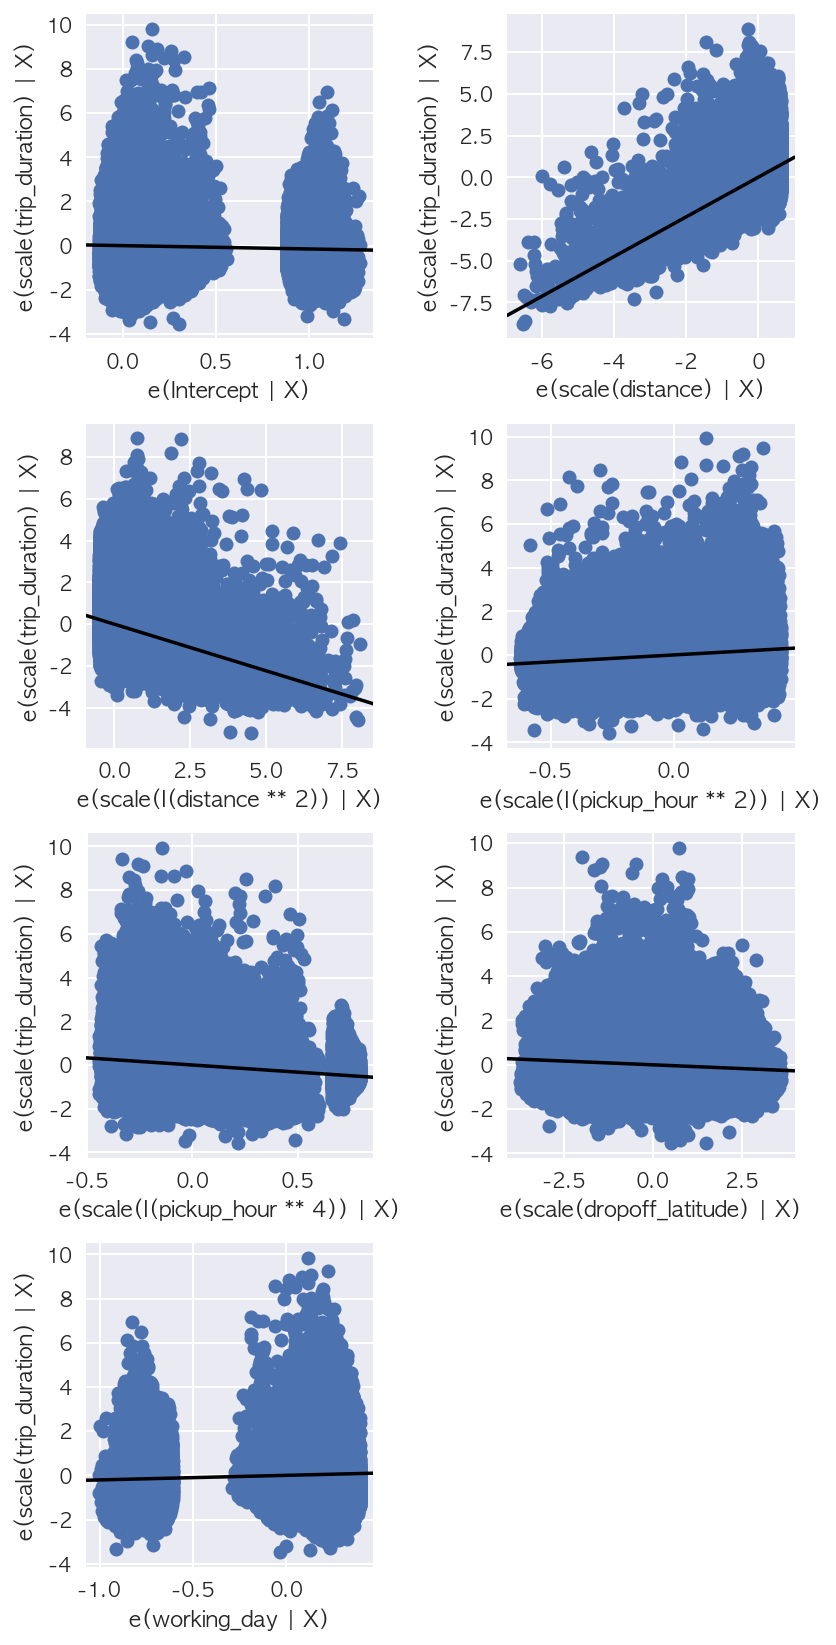

In [77]:
fig = plt.figure(figsize=(6, 12))
sm.graphics.plot_partregress_grid(result_08, fig=fig)
fig.suptitle("")
plt.show()

In [90]:
model = sm.OLS.from_formula("scale(trip_duration) ~ scale(distance) + scale(I(distance**2))+" 
                            "scale(np.exp(bearing)) + scale(I(pickup_hour**2)) + scale(I(pickup_hour**4))+"
                            "scale(dropoff_latitude) + working_day", train_out_01)
result_11 = model.fit()
print(result_11.summary())

                             OLS Regression Results                             
Dep. Variable:     scale(trip_duration)   R-squared:                       0.686
Model:                              OLS   Adj. R-squared:                  0.686
Method:                   Least Squares   F-statistic:                 3.844e+05
Date:                  Tue, 13 Mar 2018   Prob (F-statistic):               0.00
Time:                          17:01:41   Log-Likelihood:            -1.0327e+06
No. Observations:               1230258   AIC:                         2.065e+06
Df Residuals:                   1230250   BIC:                         2.065e+06
Df Model:                             7                                         
Covariance Type:              nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------


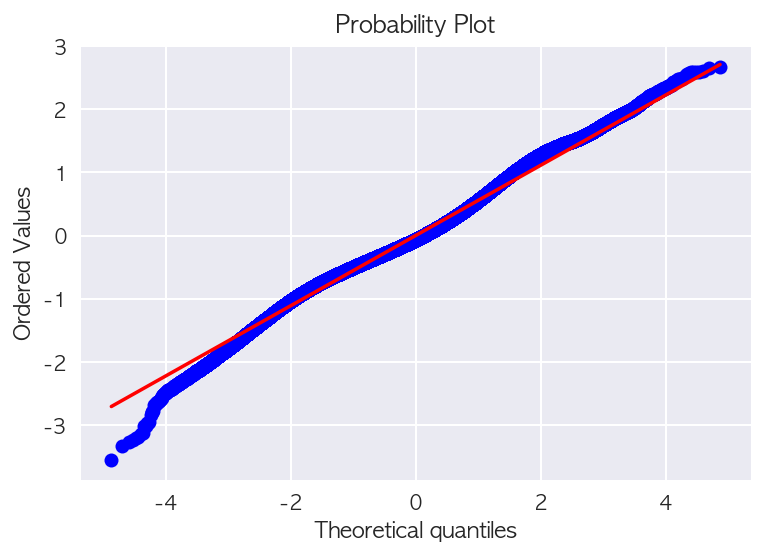

In [91]:
sp.stats.probplot(result_11.resid, plot=plt)
plt.show()

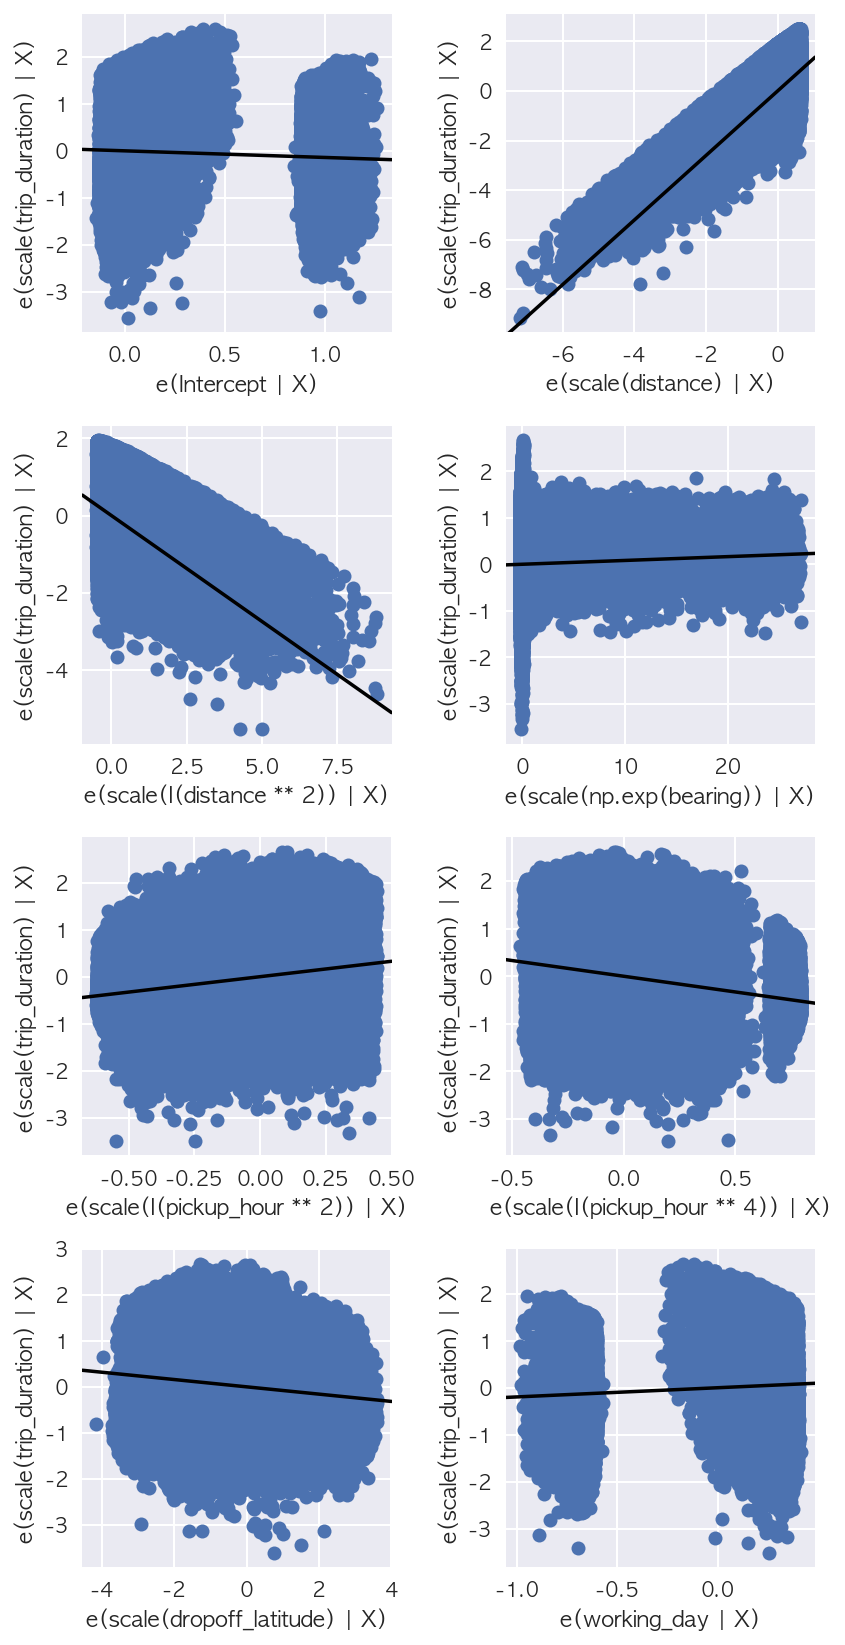

In [149]:
fig = plt.figure(figsize=(6, 12))
sm.graphics.plot_partregress_grid(result_11, fig=fig)
fig.suptitle("")
plt.show()

In [ ]:
cooks_d2, pvals = influence.cooks_distance
fox_cr = 4 / (len(y) - 2)
idx = np.where(cooks_d2 > fox_cr)[0]

plt.figure(figsize=(8, 5))
ax = plt.subplot()
plt.scatter(y, y_hat)
plt.scatter(y[idx], y_hat[idx], s=300, c="r", alpha=0.5)
utils.annotate_axes(range(len(idx)), idx, 
                    list(zip(y[idx], y_hat[idx])), [(-20, 15)] * len(idx), size="small", ax=ax)
plt.show()